# Stark shift for SrF molecule

In [1]:
import numpy as np
from numpy.linalg import eigh
import matplotlib.pyplot as plt
import pandas
import sys, os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from diatomic import hyperfine_hamiltonian_no_field, Stark_dc_hamiltonian, SrFConstants, calc_electric_dipole_moment, sort_eigenstates

## DC Stark shift

### Small electric field

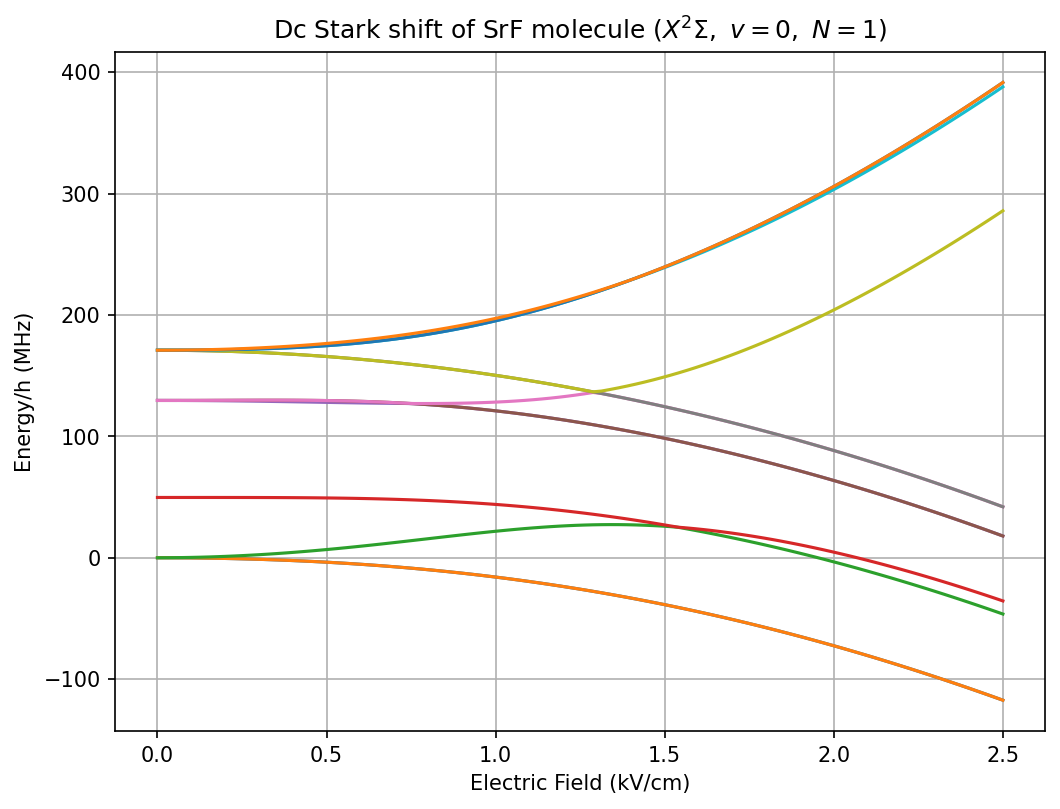

In [2]:
Nmax = 6 # Electric field mixes rotational levels, so we need to include up to sufficiently high Nmax to converge the result
H0 = hyperfine_hamiltonian_no_field(Nmax, SrFConstants) # generate field-free hamiltonian
Hdc = Stark_dc_hamiltonian(Nmax, SrFConstants, Efield=np.array([0, 0, 1])) # generate dc Stark hamiltonian for unit electric field

energy_list = np.array([])
Ez_list = np.linspace(0, 2.5, 100)
for Ez in Ez_list:
    H = H0 + Hdc * Ez
    energies, states = eigh(H)
    energy_list = np.append(energy_list, energies[4:16]/1e6) # only keep energies of N=1 rotational levels

energy_list -= energy_list[0]
energy_list = energy_list.reshape((-1, 12))

plt.figure(figsize=(8, 6), dpi=150)
plt.plot(Ez_list, energy_list)

plt.ylabel("Energy/h (MHz)")
plt.xlabel("Electric Field (kV/cm)")
plt.title("Dc Stark shift of SrF molecule ($X^2\Sigma,\ v=0,\ N=1$)")
plt.grid()
plt.show()


### Up to large electric field

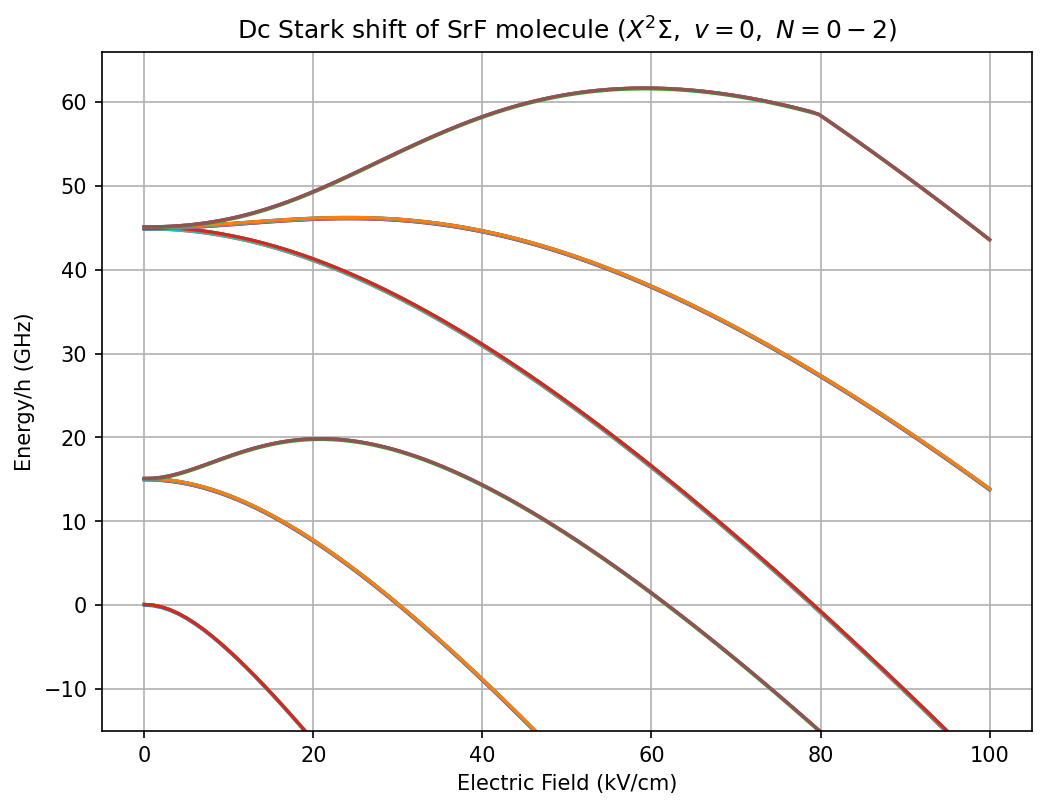

In [3]:
Nmax = 8 # Electric field mixes rotational levels, so we need to include up to sufficiently high Nmax to converge the result
H0 = hyperfine_hamiltonian_no_field(Nmax, SrFConstants) # generate field-free hamiltonian
Hdc = Stark_dc_hamiltonian(Nmax, SrFConstants, Efield=np.array([0, 0, 1])) # generate dc Stark hamiltonian for unit electric field

energy_list = np.array([])
Ez_list = np.linspace(0, 100, 100)
for Ez in Ez_list:
    H = H0 + Hdc * Ez
    energies, states = eigh(H)
    energy_list = np.append(energy_list, energies[0:36]/1e9) # only keep energies up to N=2 rotational level

energy_list -= energy_list[0]
energy_list = energy_list.reshape((-1, 36))

plt.figure(figsize=(8, 6), dpi=150)
plt.plot(Ez_list, energy_list)
plt.ylim(-15, 66)

plt.ylabel("Energy/h (GHz)")
plt.xlabel("Electric Field (kV/cm)")
plt.title("Dc Stark shift of SrF molecule ($X^2\Sigma,\ v=0,\ N=0-2$)")
plt.grid()
plt.show()


### Compared to J. Mol. Spectrosc. 300 (2014) 22-25

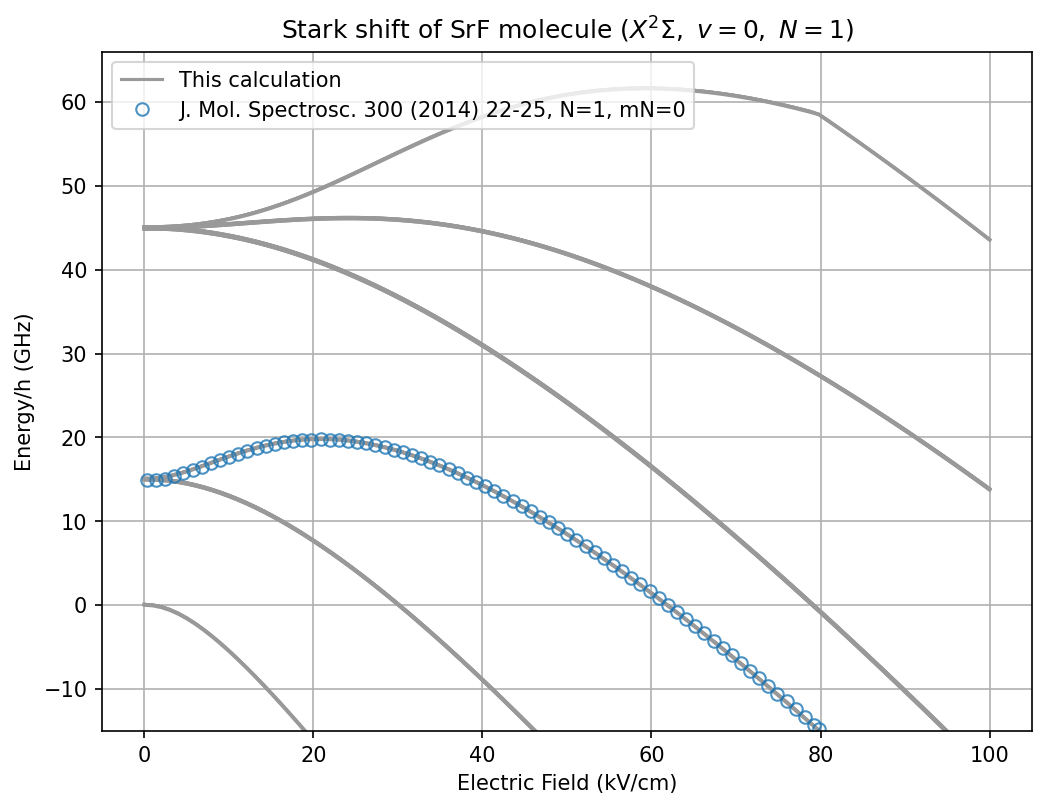

In [10]:
Nmax = 8
H0 = hyperfine_hamiltonian_no_field(Nmax, SrFConstants) # generate field-free hamiltonian
Hdc = Stark_dc_hamiltonian(Nmax, SrFConstants, Efield=np.array([0, 0, 1])) # generate dc Stark hamiltonian for unit electric field

energy_list = np.array([])
Ez_list = np.linspace(0, 100, 100) # Gauss, generate a list of B field
for Ez in Ez_list:
    H = H0 + Hdc * Ez
    energies, states = eigh(H) # diagonalize matrix
    energy_list = np.append(energy_list, energies[0:36]/1e9) # only keep energies up to N=2 rotational levels

energy_list -= energy_list[0]
energy_list = energy_list.reshape((-1, 36))

df = pandas.read_csv('JMS300(2014)22-25Fig1DataForStarkShift.csv') # John Barry's calculation of Zeeman shift (thesis Fig 2.5)
df['Energy (cm-1)'] -= df['Energy (cm-1)'][0] # remove energy offset
literature_energy_GHz = df['Energy (cm-1)'] * 29.9792458 # convert to GHz
literature_energy_GHz += energy_list[0][4] # add energy offset

fig = plt.figure(figsize=(8, 6), dpi=150)
ax = fig.add_subplot(1,1,1)
ax.plot(Ez_list, energy_list, color ='#999999', label='This calculation')
ax.plot(df['E field (kV/cm)'], literature_energy_GHz, 'o', markerfacecolor='none', alpha=0.8, label="J. Mol. Spectrosc. 300 (2014) 22-25, N=1, mN=0")
ax.set_ylim(-15, 66)

handles, labels = ax.get_legend_handles_labels()
display = (0,36)

ax.set_ylabel("Energy/h (GHz)")
ax.set_xlabel("Electric Field (kV/cm)")
ax.set_title("Stark shift of SrF molecule ($X^2\Sigma,\ v=0,\ N=1$)")
ax.legend([handle for i,handle in enumerate(handles) if i in display],
            [label for i,label in enumerate(labels) if i in display], loc='upper left')
plt.grid()
plt.show()

## Induced lab-frame electric dipole moment

### Small electric field

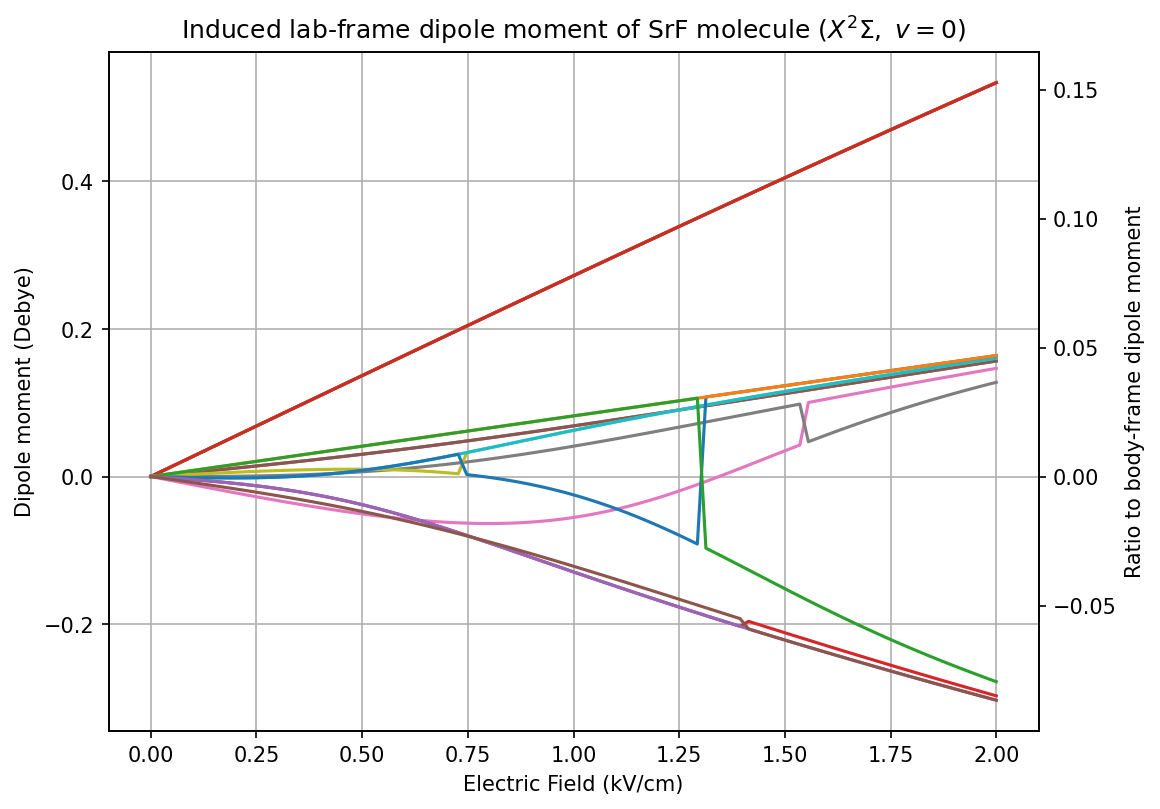

In [20]:
Nmax = 5 # Electric field mixes rotational levels, so we need to include up to sufficiently high Nmax to converge the result
H0 = hyperfine_hamiltonian_no_field(Nmax, SrFConstants) # generate field-free hamiltonian
Hdc = Stark_dc_hamiltonian(Nmax, SrFConstants, Efield=np.array([0, 0, 1])) # generate dc Stark hamiltonian for unit electric field

Ez_list = np.linspace(0, 2, 100)
energies_list = np.empty((len(Ez_list), 16), dtype=np.complex_)
states_list = np.empty((len(Ez_list), H0.shape[0], 16), dtype=np.complex_)
for i, Ez in enumerate(Ez_list):
    H = H0 + Hdc * Ez
    energies, states = eigh(H)
    energies_list[i, :] = energies[0:16]
    states_list[i, :, 0:16] = states[:, 0:16]

energies_list, states_list = sort_eigenstates(energies_list, states_list)
dipole_moment_list = calc_electric_dipole_moment(Nmax=Nmax, states=np.hstack(states_list), consts=SrFConstants) # calc_electric_dipole_moment only takes 2D array for argument states
dipole_moment_list = dipole_moment_list[:, 2] # z component only
dipole_moment_list = dipole_moment_list.reshape((-1, 16))

fig = plt.figure(figsize=(8, 6), dpi=150)
ax1 = fig.add_subplot(1,1,1)
ax1.plot(Ez_list, dipole_moment_list[:, 0:16])
# ax1.plot(Ez_list, dipole_moment_list[:, 0:4], color="C0", label="$N=0, mN=0$")
# ax1.plot(Ez_list, dipole_moment_list[:, 4:12], color="C1", label="$N=1, mN=\pm1$")
# ax1.plot(Ez_list, dipole_moment_list[:, 12:16], color="C2", label="$N=1, mN=0$")

# handles, labels = ax1.get_legend_handles_labels()
# display = (0,4,12)

ax1.set_ylabel("Dipole moment (Debye)")
ax1.set_xlabel("Electric Field (kV/cm)")
ax1.set_title("Induced lab-frame dipole moment of SrF molecule ($X^2\Sigma,\ v=0$)")
ax1.grid(True)
# ax1.legend([handle for i,handle in enumerate(handles) if i in display],
#             [label for i,label in enumerate(labels) if i in display], loc='upper left')

ax2 = ax1.twinx()
ymin, ymax = ax1.get_ylim()
ax2.set_ylim(ymin/SrFConstants.DipoleMoment_d, ymax/SrFConstants.DipoleMoment_d)
ax2.set_ylabel('Ratio to body-frame dipole moment')

plt.show()

### Up to large electric field

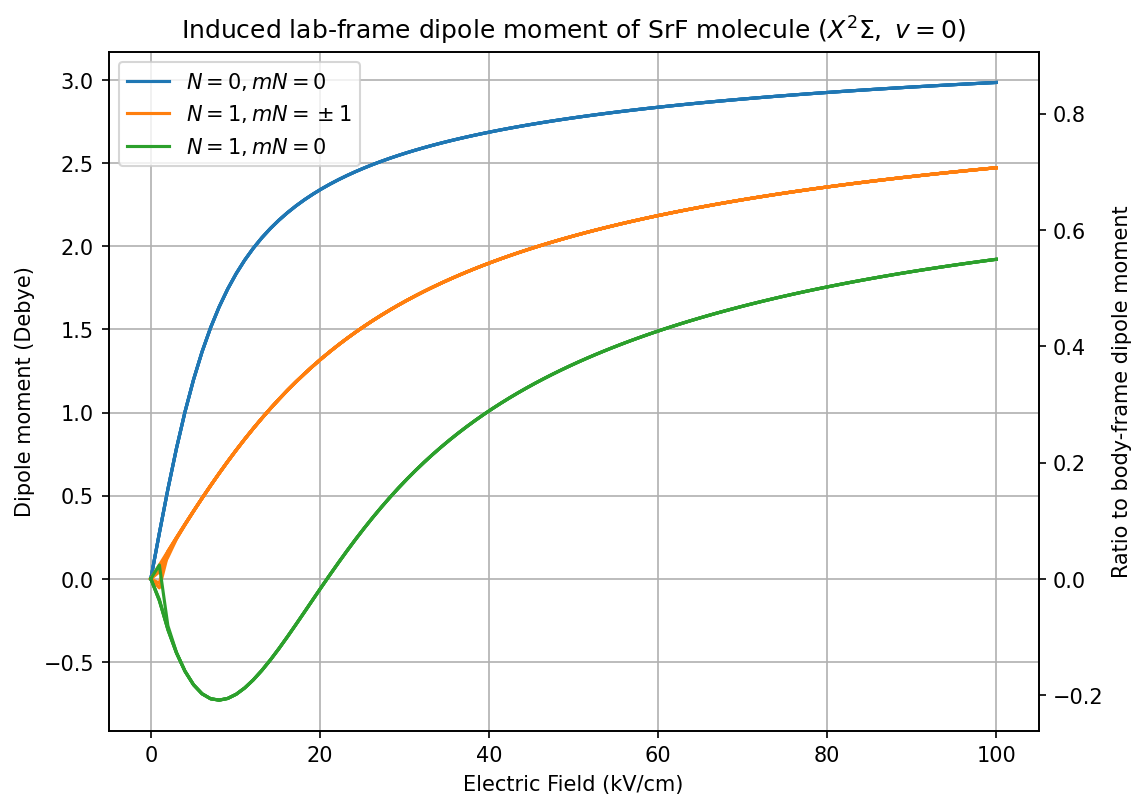

In [17]:
Nmax = 5 # Electric field mixes rotational levels, so we need to include up to sufficiently high Nmax to converge the result
H0 = hyperfine_hamiltonian_no_field(Nmax, SrFConstants) # generate field-free hamiltonian
Hdc = Stark_dc_hamiltonian(Nmax, SrFConstants, Efield=np.array([0, 0, 1])) # generate dc Stark hamiltonian for unit electric field

Ez_list = np.linspace(0, 100, 100)
states_list = np.empty((H0.shape[0], 16*len(Ez_list)), dtype=np.complex_)
for i, Ez in enumerate(Ez_list):
    H = H0 + Hdc * Ez
    energies, states = eigh(H)
    states_list[:, i*16:(i+1)*16] = states[:, 0:16]

dipole_moment_list = calc_electric_dipole_moment(Nmax=Nmax, states=states_list, consts=SrFConstants)
dipole_moment_list = dipole_moment_list[:, 2] # z component only
dipole_moment_list = dipole_moment_list.reshape((-1, 16))

fig = plt.figure(figsize=(8, 6), dpi=150)
ax1 = fig.add_subplot(1,1,1)
ax1.plot(Ez_list, dipole_moment_list[:, 0:4], color="C0", label="$N=0, mN=0$")
ax1.plot(Ez_list, dipole_moment_list[:, 4:12], color="C1", label="$N=1, mN=\pm1$")
ax1.plot(Ez_list, dipole_moment_list[:, 12:16], color="C2", label="$N=1, mN=0$")

handles, labels = ax1.get_legend_handles_labels()
display = (0,4,12)

ax1.set_ylabel("Dipole moment (Debye)")
ax1.set_xlabel("Electric Field (kV/cm)")
ax1.set_title("Induced lab-frame dipole moment of SrF molecule ($X^2\Sigma,\ v=0$)")
ax1.grid(True)
ax1.legend([handle for i,handle in enumerate(handles) if i in display],
            [label for i,label in enumerate(labels) if i in display], loc='upper left')

ax2 = ax1.twinx()
ymin, ymax = ax1.get_ylim()
ax2.set_ylim(ymin/SrFConstants.DipoleMoment_d, ymax/SrFConstants.DipoleMoment_d)
ax2.set_ylabel('Ratio to body-frame dipole moment')

plt.show()

## Convergence test

Remain to be done, test convergence vs Nmax